In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV


import plotly as py
import plotly.io as pio
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

# Mute sklearn warnings
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)
simplefilter(action='ignore', category=DeprecationWarning)

# Show charts when running kernel
init_notebook_mode(connected=True)

# Change default background color for all cvisualizations
layout=go.Layout(paper_bgcolor='rgba(0,0,0,0)', plot_bgcolor='rgba(250,250,250,0.8)')
fig = go.Figure(layout=layout)
templated_fig = pio.to_templated(fig)
pio.templates['my_template'] = templated_fig.layout.template
pio.templates.default = 'my_template'


In [5]:
df = pd.read_csv("../data/axis_bank/axis_bank_data_indicators.csv")
df.head()

,Date,Open Price,High,Low,Close Price,Total Traded Quantity,SMA,EWMA5,MiddleBand,UpperBand,LowerBand,RSI,MFI,ForceIndex,ATR,EMV
0,05-Dec-00,8.69,8.90,8.60,8.87,74876,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,06-Dec-00,8.98,9.02,8.80,8.95,61325,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4906.00,0.260,NaN
2,07-Dec-00,8.92,9.08,8.92,8.94,25832,NaN,NaN,NaN,NaN,NaN,80.000000,NaN,-258.32,0.190,56.571958
3,08-Dec-00,9.05,9.30,8.93,9.10,67535,NaN,8.999692,NaN,NaN,NaN,97.297297,NaN,10805.60,0.265,59.374590
4,11-Dec-00,9.22,9.82,9.22,9.82,131575,9.136,9.314597,9.136,9.918892,8.353108,99.692308,NaN,94734.00,0.485,123.844954


In [6]:
test_size  = 0.15
valid_size = 0.15

test_split_idx  = int(df.shape[0] * (1-test_size))
valid_split_idx = int(df.shape[0] * (1-(valid_size+test_size)))

train_df  = df.loc[:valid_split_idx].copy()
valid_df  = df.loc[valid_split_idx+1:test_split_idx].copy()
test_df   = df.loc[test_split_idx+1:].copy()

In [13]:
# drop_cols = ['Symbol', 'Total Traded Quantity', 'Open Price', 'High',"Average Trading Price",'52 Week Low','52 Week High','MiddleBand','LowerBand','UpperBand']
temp = df
drop_cols = ['Open Price', 'Low', 'High','MiddleBand','LowerBand','UpperBand','Date']
# drop_cols = ['Total Traded Quantity']
# drop_cols=["Open Price","High","MiddleBand","UpperBand","LowerBand"]

train_df = train_df.drop(columns=drop_cols)
valid_df = valid_df.drop(columns=drop_cols)
test_df  = test_df.drop(columns=drop_cols)

In [14]:
train_df.head()

,Close Price,SMA,EWMA5,RSI,MFI,ForceIndex,ATR,EMV
0,8.87,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,8.95,NaN,NaN,NaN,NaN,4906.00,0.260,NaN
2,8.94,NaN,NaN,80.000000,NaN,-258.32,0.190,56.571958
3,9.10,NaN,8.999692,97.297297,NaN,10805.60,0.265,59.374590
4,9.82,9.136,9.314597,99.692308,NaN,94734.00,0.485,123.844954


In [15]:

cols = ["Close Price"]
y_train = train_df['Close Price'].copy()
X_train = train_df.drop(columns=cols)

y_valid = valid_df['Close Price'].copy()
X_valid = valid_df.drop(columns=cols)

y_test  = test_df['Close Price'].copy()
X_test  = test_df.drop(columns=cols)

X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2992 entries, 0 to 2991
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   SMA         2988 non-null   float64
 1   EWMA5       2989 non-null   float64
 2   RSI         2990 non-null   float64
 3   MFI         2979 non-null   float64
 4   ForceIndex  2991 non-null   float64
 5   ATR         2991 non-null   float64
 6   EMV         2990 non-null   float64
dtypes: float64(7)
memory usage: 163.8 KB


In [16]:
# TODO: FIX THE WARNINGS
# run for 5 mid cap stocks, high cap stocks etc
parameters = {
    'n_estimators': range(100,1000,100),#500
    'learning_rate': [0.001, 0.005, 0.01, 0.05], 	
    'max_depth': [8, 10, 12, 15,20,32], #8
    'gamma': [0.001, 0.005, 0.01, 0.02],#0.001
    'random_state': [42]
}

eval_set = [(X_train, y_train), (X_valid, y_valid)]
model = xgb.XGBRegressor(eval_set=eval_set, objective='reg:squarederror', verbose=False,random_state=42,silent=True)
clf = GridSearchCV(model, parameters,verbose=False)

clf.fit(X_train, y_train)

print(f'Best params: {clf.best_params_}')
print(f'Best validation score = {clf.best_score_}')


[17:58:49] WARNING: ../src/learner.cc:767: 
Parameters: { "eval_set", "silent", "verbose" } are not used.

[17:58:49] WARNING: ../src/learner.cc:767: 
Parameters: { "eval_set", "silent", "verbose" } are not used.

[17:58:49] WARNING: ../src/learner.cc:767: 
Parameters: { "eval_set", "silent", "verbose" } are not used.

[17:58:50] WARNING: ../src/learner.cc:767: 
Parameters: { "eval_set", "silent", "verbose" } are not used.

[17:58:50] WARNING: ../src/learner.cc:767: 
Parameters: { "eval_set", "silent", "verbose" } are not used.

[17:58:50] WARNING: ../src/learner.cc:767: 
Parameters: { "eval_set", "silent", "verbose" } are not used.

[17:58:50] WARNING: ../src/learner.cc:767: 
Parameters: { "eval_set", "silent", "verbose" } are not used.

[17:58:51] WARNING: ../src/learner.cc:767: 
Parameters: { "eval_set", "silent", "verbose" } are not used.

[17:58:51] WARNING: ../src/learner.cc:767: 
Parameters: { "eval_set", "silent", "verbose" } are not used.



KeyboardInterrupt: 

In [32]:
parameters = {
    'n_estimators': 500,
    'learning_rate': 0.05,
    'max_depth': 128,
    # 'gamma':0.001,
    'random_state': 42
}

model = xgb.XGBRegressor(**parameters, objective='reg:squarederror')
model.fit(X_train, y_train, eval_set=eval_set, verbose=False)

[18:15:54] WARNING: ../src/learner.cc:339: No visible GPU is found, setting `gpu_id` to -1


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=1, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=128, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=500, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=42, ...)

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

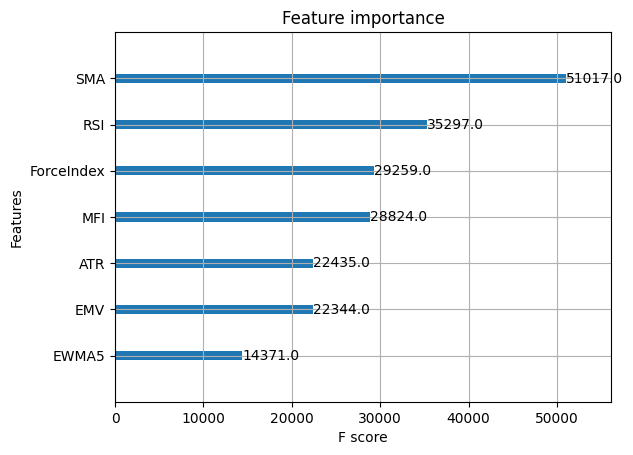

In [33]:
plot_importance(model)

In [34]:
y_pred = model.predict(X_test)
print(f'y_true = {np.array(y_test)[:9]}')
print(f'y_pred = {y_pred[:9]}')


y_true = [583.9  585.8  577.05 571.8  578.2  581.95 583.6  584.55 608.75]
y_pred = [315.46683 316.57538 311.48862 309.1178  314.9541  316.33823 316.57538
 317.6236  317.2343 ]


In [35]:
print(f'mean_squared_error = {mean_squared_error(y_test, y_pred)}')

mean_squared_error = 38248.15614654278


In [36]:
predicted_prices = df.loc[test_split_idx+1:].copy()
predicted_prices['Close Price'] = y_pred
predicted_prices.head()

fig = make_subplots(rows=2, cols=1)
fig.add_trace(go.Scatter(x=temp.index, y=df['Close Price'],
                         name='Truth',
                         marker_color='LightSkyBlue'), row=1, col=1)

fig.add_trace(go.Scatter(x=predicted_prices.index,
                         y=predicted_prices['Close Price'],
                         name='Prediction',
                         marker_color='MediumPurple'), row=1, col=1)

fig.add_trace(go.Scatter(x=predicted_prices.index,
                         y=y_pred,
                         marker_color='MediumPurple',
                         showlegend=False), row=2, col=1)

fig.show()